# Projet 4 - Statistiques Grandes Dimensions

In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model as skl_linear_mdl
import sklearn.model_selection as skl_mdl_selection
import sklearn.metrics as skl_metrics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

In [2]:
def print_plot(subtitle,ttle,xlab,ylab):
    plt.figure()
    plt.suptitle(subtitle,
                fontsize=14)
    plt.title(ttle, fontsize=10)
    plt.ylabel(ylab)
    plt.xlabel(xlab)  

In [3]:
def print_plot3D(subtitle,ttle,xlab,ylab,zlab,alpha_rge,lambda_rge,quad_risk,toPivot):
    fig = plt.figure(figsize=(7,7))
    plt.suptitle(subtitle)
    ax = fig.add_subplot(111, projection='3d')
    alpha_axis, lambda_axis = np.meshgrid(alpha_rge, lambda_rge)
    if toPivot==0:
        ax.plot_surface(alpha_axis, lambda_axis, quad_risk.values)
    elif toPivot==1:
        ax.plot_surface(lambda_axis,alpha_axis,  all_quad_risk.values)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_zlabel(zlab)
    plt.show()

# Exercice 1 - Régularisation

$$ \textbf{Objectif du projet:} $$
Dans ce projet, nous testerons différents estimateurs utilisés dans la prédiction de variables afin d'observer dans quel cas ceux-ci sont les plus appropriés.
Les estimateurs sont les suivants:
-Lasso
-Ridge
-Elastic Net

On rappelle:
*Lasso:
$$ \hat{\beta^L}=argmin L_{\lambda}(\beta) \text{où } L_{\lambda}(\beta) =\frac{1}{2n}\sum_{i=1}^n(Y_i-X_i*\beta)² + \lambda||\beta||_1 \text{avec }(\lambda>1) $$
*Ridge
$$ \hat{\beta^R}=argmin R_{\mu}(\beta) \text{où } R_{\mu}(\beta) =\frac{1}{2n}\sum_{i=1}^n(Y_i-X_i*\beta)² + \frac{\mu}{2}||\beta||_2^2 \text{avec }(\mu>0) $$
* Elastic Net
$$ \hat{\beta^{EN}}=argmin F_{\lambda}(\beta) \text{où } F_{\lambda}(\beta) =\frac{1}{2n}\sum_{i=1}^n(Y_i-X_i*\beta)² + \lambda(\alpha||\beta||_1 + \frac{1-\alpha}{2}||\beta||_2^2)$$


# Question 1

### Simulation de X et Y

 * On simule une matrice X (1000 * 5000) où chaque coordonnée suit une loi normale centrée réduite
 * On simule un vecteur eta de (1000 * 1) où chaque coordonnée suit une loi normale centrée réduite
 * On fixe un vecteur beta de (5000 * 1000) où chaque coordonnée est nulle, à l'exception des 15 premières qui valent 1
 * On calcul finalement le Y simulé, qui est égale à X * beta + eta
 * Enfin, on construit notre dataset, qui est composé du Y en première colonne (c'est la target) et des X sur les 5000 colonnes suivantes (ce sont les features simulées)

In [5]:
# Simulating X
xindex = ["X" + str(i) for i in range(1, 5001)]
X = pd.DataFrame(np.reshape(np.random.normal(0, 1, (1000*5000)), (1000, 5000)),columns=xindex)
# Simulating Eta
eta = pd.DataFrame(np.random.normal(0, 1, 1000), columns=["Eta"])
# Fixing Beta
beta = pd.DataFrame(np.repeat(0, 5000), columns=["Beta"])
for i in range(0, 15):
    beta.loc[i, ] = 1

# Compute simulated Y
Y = pd.DataFrame(np.dot(X, beta) + eta.values,columns=["Y"])
dataset=pd.DataFrame()

dataset = Y
dataset[xindex] = X

dataset.head(5)

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X4991,X4992,X4993,X4994,X4995,X4996,X4997,X4998,X4999,X5000
0,-9.495247,0.252529,0.978173,-1.648376,-0.745150,-0.549010,0.262922,-1.853830,-1.433932,-1.381969,...,1.249191,0.614602,0.257282,2.753593,0.191534,-0.458562,0.659595,-1.540402,-1.696091,-0.216240
1,1.057552,1.533244,2.006552,-0.190147,0.194154,-0.079179,-2.006603,-0.960380,-0.295381,0.505217,...,0.870553,0.931574,1.179348,-1.245467,0.303608,-1.480956,2.010872,-0.051878,2.459523,-0.175188
2,5.028802,-0.166424,2.203721,0.553657,-0.116348,1.172426,-1.116846,0.268590,0.096138,1.504544,...,0.253599,-0.174195,1.164225,1.068989,1.193183,-0.046513,1.621068,-0.521043,0.587093,-0.134657
3,2.892730,-0.163507,1.075256,0.880031,-0.866662,0.829735,-0.632193,0.224687,2.140223,-0.254601,...,-1.532971,0.734220,-2.213476,-1.355496,-1.487412,-1.778325,1.236865,0.480267,-0.984885,-0.917793
4,9.268786,0.235276,0.227232,0.300307,0.607062,1.144957,0.806097,1.982821,2.302154,-0.770721,...,0.209895,0.528178,1.088278,0.738285,-1.541232,1.805350,-0.605179,-0.866061,0.621735,-0.598873


### Séparation du dataset en Train / Test

 * On sépare assez classiquement le dataset en 2 parties :
        le train set, 66% des données
        le test set, 34% des données
 
On utilise pour cela la fonction de sklearn : train_test_split

In [6]:
# Splitting X in training and testing set
train_set, test_set = skl_mdl_selection.train_test_split(dataset,
                                                        train_size=0.66,
                                                        test_size=0.34)

X_train = train_set.iloc[:, 1:]
Y_train = train_set.iloc[:, 0]
X_test = test_set.iloc[:, 1:]
Y_test = test_set.iloc[:, 0]

X_train.head(5)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X4991,X4992,X4993,X4994,X4995,X4996,X4997,X4998,X4999,X5000
241,-0.411098,-0.145020,-0.601383,-1.016331,-1.211025,0.230308,0.108508,1.038159,-0.035076,0.241963,...,-0.216262,0.599253,-1.062285,-0.844311,-2.037630,1.039755,0.369866,0.073692,2.185047,-0.961506
96,-0.909034,-0.605538,0.102225,0.542965,1.159063,-1.391814,-0.927249,-0.325360,-1.691028,-1.453019,...,1.991209,-0.032368,-1.259970,0.302735,1.830717,-0.267040,1.010104,1.145018,1.549268,1.234028
518,-1.109685,1.652172,-0.291129,0.912655,0.855644,0.826285,-0.448934,-1.040584,-1.312625,-0.082198,...,0.820791,2.303144,0.472122,0.361112,-0.138547,-0.385430,-0.720588,1.084893,-0.397409,-0.706167
576,-0.837278,1.048874,-1.053501,-0.572636,-1.135570,0.940757,0.164049,-1.177026,0.284111,-0.776715,...,-0.873612,-0.215861,-0.339654,1.017378,-0.062421,-2.025236,-1.283571,-1.305765,0.573330,-0.256140
35,0.880089,-0.184881,0.117213,0.231647,-1.480395,1.665049,1.736750,-0.729738,1.122556,-1.219183,...,0.592456,1.162374,0.742223,-0.217050,-1.052846,0.237344,-1.439791,-0.915768,-0.643530,0.887570


### A) On estime la Régression Elastic Net pour alpha variant de 0 à 1

 On estime les 5000 coefficients pour alpha variant entre 0 et 1 (lambda est égal à 1): 
 * on crée un range de alpha de taille 11
 * on itère sur ce range, en calculant à chaque itération le vecteur beta estimé de (5000*1)
 * on remplit un dictionnaire qui contiendra les 5000 * 11 betas issus de nos simulations

In [7]:
def elastic_net_return_coeff(iterateOnL1 ,alpha_value, l1ratio_value, X_train, Y_train):
    all_beta_chap = dict()
    toIterate = np.linspace(0, 1, 11)
    for i_toIterate in toIterate:
        
        if iterateOnL1==True:
            lasso = skl_linear_mdl.ElasticNet(alpha=alpha_value, l1_ratio=i_toIterate,
                                              fit_intercept=False)#, max_iter = 10000)
            
        if iterateOnL1==False:
            lasso = skl_linear_mdl.ElasticNet(alpha=i_toIterate, l1_ratio=l1ratio_value,
                                              fit_intercept=False)#, max_iter = 10000)
            
        lasso.fit(X_train, Y_train)
        beta_chap = lasso.coef_
        
        all_beta_chap.update({i_toIterate: beta_chap})

    return all_beta_chap

 * Affichage des coefficients pour chaque valeur de alpha

On affiche, pour chacun des 5000 betas, sa valeur en fonction de alpha
On peut donc observer dans quelle mesure le modèle shrinke les coefficients en fonction de la valeur de alpha.
Dans notre cas, on sais que 15 coefficients sont égaux à 1, tandis que les 4985 autres sont nuls :
 * on observe sur le graphique que pour un alpha entre 0 et 0.2, nos 15 coefficients valent à peu près 0.5, et que leur variance diminue à mesure que alpha augmente. Cependant, ils sont en moyenne de plus en plus éloigné de leurs vrais valeurs (à savoir, 1), et sont tous nuls lorsque alpha vaut 1.
 * En ce qui concerne les 4985 coefficients nuls, leur variance est élevé pour un alpha proche de zéro (et ils ne sont donc pas tous nuls). En revanche, dès que alpha augmente, ils deviennts tous nuls (leurs vraie valeur)
 
         La bonne valeur de alpha est donc un peu éloigné de 0 (afin que les 4985 coefficents nuls soient estimés comme tels), tout en veillant à ce que les 15 coefficients unitaires soient assez proches de leurs vrai valeur : graphiquement, on situe le alpha optimal (à lambda fixe) entre 0.2 et 0.3

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0
0,0.100806,0.323203,0.417339,0.409784,0.373449,0.331859,0.284457,0.229974,0.165231,0.086854,0.000000
1,0.106871,0.327132,0.413363,0.406178,0.370956,0.329974,0.283242,0.229451,0.170432,0.100176,0.013836
2,0.074613,0.237693,0.306034,0.284478,0.230360,0.166249,0.090825,0.000873,0.000000,0.000000,0.000000
3,0.100188,0.283142,0.341606,0.319563,0.272003,0.216055,0.150631,0.073064,0.000000,0.000000,0.000000
4,0.120269,0.324353,0.421593,0.413410,0.382287,0.347236,0.308203,0.264556,0.214905,0.152503,0.076177
5,0.104607,0.301891,0.391174,0.379363,0.339577,0.293497,0.240428,0.178629,0.105620,0.020721,0.000000
6,0.119875,0.351485,0.442831,0.432993,0.399694,0.361618,0.318276,0.268459,0.213713,0.144600,0.070305
7,0.123641,0.363620,0.458348,0.455737,0.425183,0.389203,0.348364,0.301591,0.250769,0.196183,0.126612
8,0.149943,0.418535,0.499025,0.489648,0.463071,0.433925,0.401651,0.365799,0.328105,0.281959,0.218631
9,0.101699,0.298290,0.379534,0.360586,0.317404,0.267062,0.208529,0.139578,0.065072,0.000000,0.000000


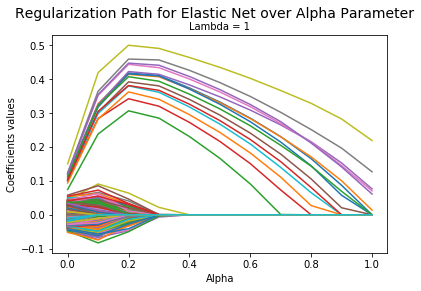

In [8]:
all_beta_chap = dict()

all_beta_chap = elastic_net_return_coeff(iterateOnL1=True,alpha_value=1,l1ratio_value=1,
                                         X_train=X_train,Y_train=Y_train)

beta_vs_alpha = pd.DataFrame(all_beta_chap)
print_plot("Regularization Path for Elastic Net over Alpha Parameter","Lambda = 1","Alpha","Coefficients values")
alpha_range=np.linspace(0,1,11)
for row in beta_vs_alpha.iterrows():
    row = row[1]
    plt.plot(alpha_range, row)

beta_vs_alpha.head(20)

### B) Chemin de Régularisation (Regularization Path) de l'estimateur Lasso

 On estime les 5000 coefficients pour lambda variant entre 0 et 1 (alpha est égal à 1): 
 * on crée un range de lambda de taille 11
 * on itère sur ce range, en calculant à chaque itération le vecteur beta estimé de (5000*1)
 * on remplit un dictionnaire qui contiendra les 5000 * 11 betas issus de nos simulations
 
De la même manière que pour le coefficient alpha, on affiche, pour chacun des 5000 betas, sa valeur en fonction de lambda :
 * On voit qu'entre 0 et 0.2, les 15 coefficients sont très proches de leurs vrai valeurs (1), puis descendent linéairement jusqu'à 0, lorsque lambdba vaut 1
 * les 4985 nuls sont un peu dispersés autour de 0, pour alpha entre 0 et 0.2. Après 0.2, les 4985 coefficients estimés sont tous nuls (égaux à leurs vrai valeur, donc)
 
         Graphiquement, on poserais un lambda égal à 0.1 ou 0.2

 * Méthode 1 : En calculant nous mêmes

In [141]:
def print_regularization_path(X_train,Y_train,isLasso=False):
    all_quad_risk = dict()
    all_beta_chap = dict()
    lambda_range = np.linspace(0, 1, 11)
    if isLasso==True:
        all_beta_chap = elastic_net_return_coeff(False,1,1,X_train,Y_train)
    if isLasso==False:
        all_beta_chap = elastic_net_return_coeff(False,1,0,X_train,Y_train)

    beta_vs_lambda = pd.DataFrame(all_beta_chap)
    if isLasso==True:
        print_plot("Lasso Regularization Path","(Alpha = 1)","Lambda","Coefficients values")
    if isLasso==False:
        print_plot("Ridge Regularization Path","(Alpha = 0)","Lambda","Coefficients values")
    for row in beta_vs_lambda.iterrows():
        row = row[1]
        plt.plot(lambda_range, row)

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


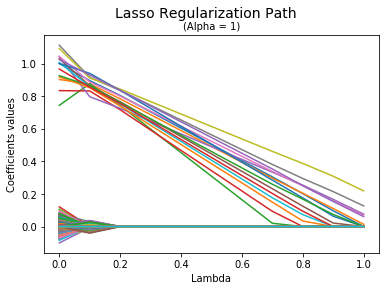

In [10]:
print_regularization_path(X_train,Y_train,isLasso=True)

 * Méthode 2 : Avec la méthode Path

In [11]:
#lasso = skl_linear_mdl.ElasticNet(l1_ratio=1)
#lasso_path = lasso.path(X_train, Y_train, l1_ratio=1)
#lasso_path_result = lasso_path[1]
#print_plot("","Lasso Regularization Path","Lambda","Coefficients values")

#for i in range(0, len(lasso_path_result)):
#    plt.plot(lasso_path[0], lasso_path_result[i])

### B.1) Chemin de Régularisation de l'estimateur Ridge

De la même manière que pour l'estimateur Lasso, on affiche, pour chacun des 5000 coefficients du modèle Ridge, leur valeur en fonction de Lambda (entre 0 et 1), pour un alpha égal à 0 (par définition du modèle Ridge)
On peut observer que les 15 coefficients unitaires tendent beaucoup plus vite vers 0 (à 0.1, ils sont déjà presque nuls)

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


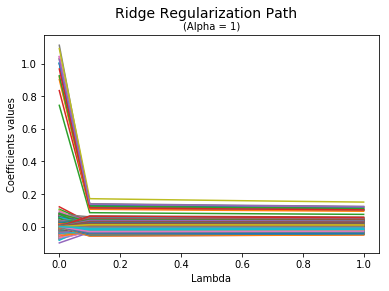

In [12]:
print_regularization_path(X_train,Y_train,False)

### C) Optimisation du / des paramètres de régularisation (lambda et alpha)

Nous allons maintenant, pour chacun des 3 modèles, optimiser leurs paramètres de régularisation :
 * Pour le Lasso, on optimise donc pour lambda entre 0 et 1, sachant qu'alpha vaut 1 (par défintion du modèle Lasso)
 * Pour le Ridge, on optimise donc pour lambda entre 0 et 1, sachant qu'alpha vaut 0 (par défintion du Ridge)
 * Pour l'Elastic Net, qui est une pondération des modèles Lasso et Ridge, on optimise donc sur lambda et sur alpha, variant tout deux entre 0 et 1 

Nous optimiserons ces paramètres par validation croisée :
 * estimation du modèle sur le training set
 * calcul du MSE par rapport au test set

In [13]:
def elastic_net_return_error(X_train, Y_train, X_test, Y_test, alpha_range, lambda_range):
    all_quad_risk = pd.DataFrame(index=alpha_range, 
                                 columns=lambda_range)

    for i_alpha in alpha_range:
        for i_lambda in lambda_range:
            en = skl_linear_mdl.ElasticNet(alpha=i_lambda, l1_ratio=i_alpha,
                                           fit_intercept = False, max_iter = 10000)
            en.fit(X_train, Y_train)
            beta_chap = en.coef_
            Y_predict = en.predict(X_test)
            quad_risk = skl_metrics.mean_squared_error(Y_test, Y_predict)
            all_quad_risk.loc[i_alpha, i_lambda] = quad_risk
        
    min_mse = all_quad_risk.min().min()
    x, y = np.where(all_quad_risk.values == min_mse)
    
    alpha_opt_elastic_net = all_quad_risk.index[x].tolist()[0]
    #lambda_opt_elastic_net = all_quad_risk.index[x].tolist()[0]
    lambda_opt_elastic_net = all_quad_risk.columns[y].tolist()[0]
    
    return lambda_opt_elastic_net, alpha_opt_elastic_net, all_quad_risk

In [14]:
def optimise_params(X_train, Y_train, X_test, Y_test, model_num):
    all_quad_risk = dict()
    
    if model_num == 1:
        alpha_opt = 1
        #lambda_opt, all_quad_risk=Elastic_Net_return_error(1, X_train, Y_train, X_test, Y_test)
        lambda_opt, _, all_quad_risk = elastic_net_return_error(X_train, Y_train, X_test, Y_test,
                                                                [alpha_opt], np.linspace(0, 1, 11)) 
    elif model_num == 2:
        alpha_opt = 0
         #lambda_opt, all_quad_risk=Elastic_Net_return_error(0, X_train, Y_train, X_test, Y_test)
        lambda_opt, _, all_quad_risk = elastic_net_return_error(X_train, Y_train, X_test, Y_test,
                                                                [alpha_opt], np.linspace(0, 1, 11)) 
    elif model_num == 3:
         lambda_opt, alpha_opt, all_quad_risk = elastic_net_return_error(X_train, Y_train, X_test, Y_test,
                                                                         np.linspace(0, 1, 11), np.linspace(0, 1, 11))  
    
    return lambda_opt, alpha_opt, all_quad_risk

def print_opt_model(alpha_opt, lambda_opt, model_num):
    if model_num == 1:
        print_plot("Lasso Regression","Lambda Optimal : " + str(lambda_opt),"Lambda","MSE")
    elif model_num == 2:
        print_plot("Ridge Regression","Lambda Optimal : " + str(lambda_opt),"Lambda","MSE")
    elif model_num == 3:
        pass

 * Lasso

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


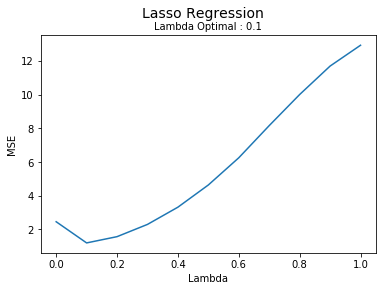

In [15]:
lambda_opt_lasso, _, all_quad_risk = optimise_params(X_train, Y_train, X_test, Y_test, model_num=1)
print_plot("Lasso Regression","Lambda Optimal : " + str(lambda_opt_lasso),"Lambda","MSE")
plt.plot(all_quad_risk.columns,
         all_quad_risk.values.reshape(11, 1))

 * Ridge

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


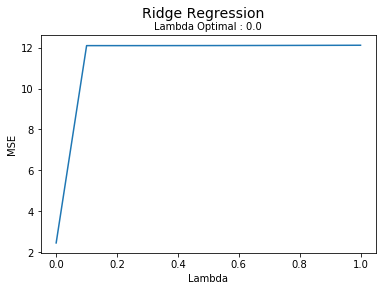

In [16]:
lambda_opt_ridge, _, all_quad_risk = optimise_params(X_train, Y_train, X_test, Y_test, model_num=2)
print_plot("Ridge Regression","Lambda Optimal : " + str(lambda_opt_ridge),"Lambda","MSE")
plt.plot(all_quad_risk.columns,
         all_quad_risk.values.reshape(11, 1))

* Elastic Net

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


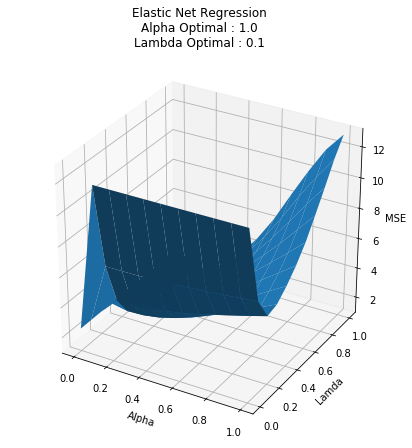

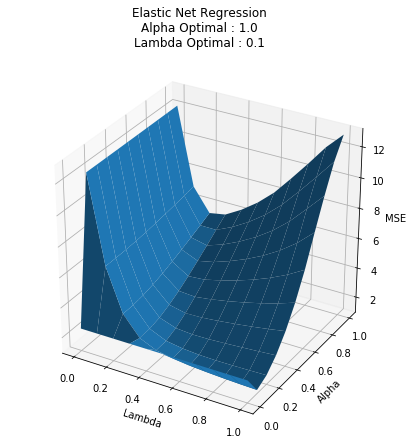

In [17]:
lambda_opt_elastic_net, alpha_opt_elastic_net, all_quad_risk = optimise_params(X_train, Y_train, X_test, Y_test, model_num=3)

print_plot3D("Elastic Net Regression\nAlpha Optimal : " + str(alpha_opt_elastic_net) +
          "\nLambda Optimal : " + str(lambda_opt_elastic_net),"", "Alpha", "Lamda", "MSE",
             np.linspace(0, 1, 11), np.linspace(0, 1, 11), all_quad_risk,0)

print_plot3D("Elastic Net Regression\nAlpha Optimal : " + str(alpha_opt_elastic_net) +
          "\nLambda Optimal : " + str(lambda_opt_elastic_net),"", "Lambda", "Alpha", "MSE",
             np.linspace(0, 1, 11), np.linspace(0, 1, 11), all_quad_risk,1)

opt_elastic_net=[]
opt_elastic_net.append(alpha_opt_elastic_net)
opt_elastic_net.append(lambda_opt_elastic_net)

### D) Score des estimateurs

Enfin, on sélectionne le meilleurs des 3 modèles, en sélectionnant celui qui affiche le MSE le plus faible. On prend également soin de calculer le coefficient de détermination R2 du modèle.

In [18]:
def score(X_train,Y_train, lambda_opt,isLasso):
    if isLasso==True:
        model = skl_linear_mdl.ElasticNet(alpha=lambda_opt, l1_ratio=1,
                                          fit_intercept=False, max_iter = 10000)
    if isLasso==False:
        model = skl_linear_mdl.ElasticNet(alpha=lambda_opt, l1_ratio=0,
                                          fit_intercept=False, max_iter = 10000)
    model.fit(X_train, Y_train)
    score_model = model.score(X_test, Y_test) 
    Y_predict = model.predict(X_test)
    mse_model = skl_metrics.mean_squared_error(Y_test, Y_predict)
    
    return[score_model,mse_model]

In [19]:
def score_elastic_net(X_train,Y_train, opt_elastic_net):
    en = skl_linear_mdl.ElasticNet(alpha=opt_elastic_net[1], l1_ratio=opt_elastic_net[0],
                                   fit_intercept=False, max_iter = 10000)
    en.fit(X_train, Y_train)
    score_en = en.score(X_test, Y_test)
    Y_predict_en = en.predict(X_test)
    mse_en = skl_metrics.mean_squared_error(Y_test, Y_predict_en)
    
    return([score_en,mse_en])

In [20]:
def print_score(X_train, Y_train, lambda_opt_lasso, lambda_opt_ridge, opt_elastic_net):
    lasso=score(X_train,Y_train,lambda_opt=lambda_opt_lasso,isLasso=True)
    score_lasso=lasso[0]
    mse_lasso=lasso[1]
    ridge=score(X_train,Y_train,lambda_opt=lambda_opt_ridge,isLasso=False)
    score_ridge=ridge[0]
    mse_ridge=ridge[1]
    en=score_elastic_net(X_train,Y_train,opt_elastic_net=opt_elastic_net)
    score_en=en[0]
    mse_en=en[1]
    
    df_score = pd.DataFrame([score_lasso, score_ridge, score_en],
                       columns=["Score (R2)"], index=["Lasso", "Ridge", "Elastic Net"])
    df_score["MSE"] = [mse_lasso, mse_ridge, mse_en]

    best_model_R2 = df_score.index[np.argmax(df_score["Score (R2)"].values)]
    best_model_mse = df_score.index[np.argmin(df_score["MSE"].values)]
    df_score.loc["BEST MODEL", "Score (R2)"] = best_model_R2
    df_score.loc["BEST MODEL", "MSE"] = best_model_mse
    print(df_score.head()) 

In [21]:
print_score(X_train,Y_train,lambda_opt_lasso,lambda_opt_ridge,opt_elastic_net)

            Score (R2)      MSE
Lasso         0.912584  1.19948
Ridge         0.821044  2.45554
Elastic Net   0.912584  1.19948
BEST MODEL       Lasso    Lasso


/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


# Question 2

On reproduit les étapes de la Question 1, sur un Dataset différent.
Pour chacun des 3 modèles :
 * On affiche le regularization Path
 * On optimise le/les paramètre(s) de régularisation

Enfin, on sélectionne le meilleur modèle

In [22]:
# Simulating X
xindex = ["X" + str(i) for i in range(1, 5001)]
X = pd.DataFrame(np.reshape(np.random.normal(0, 1, (1000*5000)), (1000, 5000)),
                    columns=xindex)
# Simulating Eta
eta = pd.DataFrame(np.random.normal(0, 1, 1000),
                      columns=["Eta"])

# Simulating Beta
beta = pd.DataFrame(np.repeat(0, 5000),
                       columns=["Beta"])
for i in range(0, 1500):
    beta.loc[i, ] = 1

# Compute simulated Y
Y = pd.DataFrame(np.dot(X, beta) + eta.values,
                columns=["Y"])

dataset=pd.DataFrame()
dataset = Y
dataset[xindex] = X

# Splitting X in training and testing set
train_set, test_set = skl_mdl_selection.train_test_split(dataset,
                                                        train_size=0.66,
                                                        test_size=0.34)

X_train = train_set.iloc[:, 1:]
Y_train = train_set.iloc[:, 0]
X_test = test_set.iloc[:, 1:]
Y_test = test_set.iloc[:, 0]

 * Lasso

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':


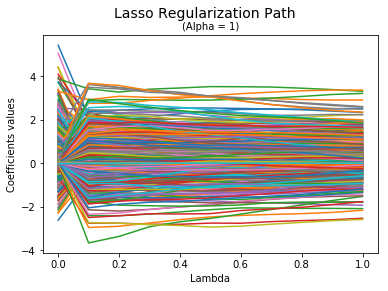

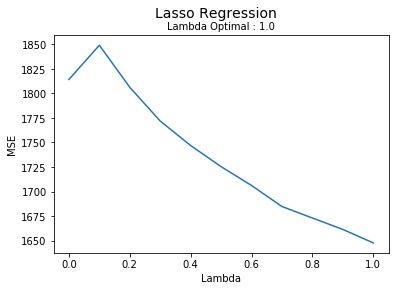

In [23]:
print_regularization_path(X_train,Y_train,isLasso=True)
lambda_opt_lasso, _, all_quad_risk = optimise_params(X_train, Y_train, X_test, Y_test, model_num=1)
print_plot("Lasso Regression","Lambda Optimal : " + str(lambda_opt_lasso),"Lambda","MSE")
plt.plot(all_quad_risk.columns,
         all_quad_risk.values.reshape(11, 1))

 * Ridge

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':


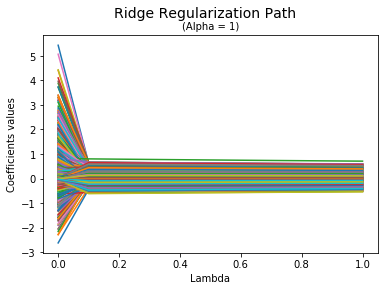

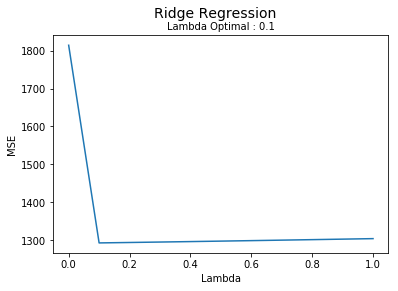

In [24]:
print_regularization_path(X_train,Y_train,isLasso=False)
lambda_opt_ridge, _, all_quad_risk = optimise_params(X_train, Y_train, X_test, Y_test, model_num=2)
print_plot("Ridge Regression","Lambda Optimal : " + str(lambda_opt_ridge),"Lambda","MSE")
plt.plot(all_quad_risk.columns,
         all_quad_risk.values.reshape(11, 1))

 * Elastic Net

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


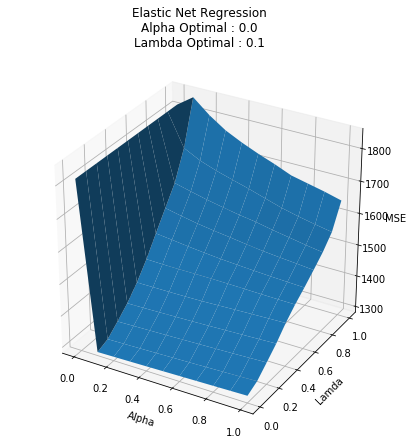

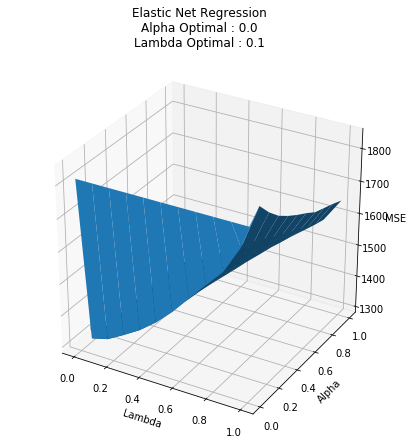

In [25]:
lambda_opt_elastic_net, alpha_opt_elastic_net, all_quad_risk = optimise_params(X_train, Y_train, X_test, Y_test, model_num=3)

print_plot3D("Elastic Net Regression\nAlpha Optimal : " + str(alpha_opt_elastic_net) +
          "\nLambda Optimal : " + str(lambda_opt_elastic_net),"", "Alpha", "Lamda", "MSE",
             np.linspace(0, 1, 11), np.linspace(0, 1, 11), all_quad_risk,0)

print_plot3D("Elastic Net Regression\nAlpha Optimal : " + str(alpha_opt_elastic_net) +
          "\nLambda Optimal : " + str(lambda_opt_elastic_net),"", "Lambda", "Alpha", "MSE",
             np.linspace(0, 1, 11), np.linspace(0, 1, 11), all_quad_risk,1)

opt_elastic_net=[]
opt_elastic_net.append(alpha_opt_elastic_net)
opt_elastic_net.append(lambda_opt_elastic_net)

 * Score

In [26]:
print_score(X_train,Y_train,lambda_opt_lasso,lambda_opt_ridge,opt_elastic_net)

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


            Score (R2)      MSE
Lasso        -0.069466  1647.65
Ridge         0.160783  1292.92
Elastic Net   0.160783  1292.92
BEST MODEL       Ridge    Ridge


# Question 3

On reproduit les étapes de la Question 1, sur un Dataset différent.
Pour chacun des 3 modèles :
 * On affiche le regularization Path
 * On optimise le/les paramètre(s) de régularisation

Enfin, on sélectionne le meilleur modèle

In [33]:
# Simulating X
xindex = ["X" + str(i) for i in range(1, 51)]
cov_mat = np.repeat(0.7, 50*50).reshape(50, 50)
for i in range(0, 50):
    for j in range(i, 50):
        cov_mat[i, j] = np.power(cov_mat[i, j], abs(i-j))
        cov_mat[j, i] = np.power(cov_mat[j, i], abs(i-j))

X = pd.DataFrame(np.reshape(np.random.multivariate_normal([0] * 50, cov_mat, 100),
                            (100, 50)),
                 columns=xindex)

# Simulating Eta
eta = pd.DataFrame(np.random.normal(0, 1, 100),
                      columns=["Eta"])
# Simulating Beta
beta = pd.DataFrame(np.repeat(0, 50),
                       columns=["Beta"])

beta.loc[0, ] = 10
beta.loc[1, ] = 10
beta.loc[2, ] = 5
beta.loc[3, ] = 5
for i in range(4, 14):
    beta.loc[i, ] = 1

# Compute simulated Y
Y = pd.DataFrame(np.dot(X, beta) + eta.values,
                columns=["Y"])

dataset = pd.DataFrame()


dataset = Y
dataset[xindex] = X

# Splitting X in training and testing set
train_set, test_set = skl_mdl_selection.train_test_split(dataset,
                                                        train_size=0.66,
                                                        test_size=0.34)

X_train = train_set.iloc[:, 1:]
Y_train = train_set.iloc[:, 0]
X_test = test_set.iloc[:, 1:]
Y_test = test_set.iloc[:, 0]

 * Lasso

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':


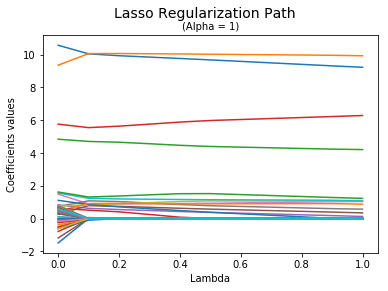

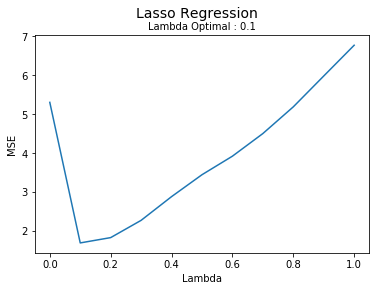

In [34]:
print_regularization_path(X_train,Y_train,isLasso=True)
lambda_opt_lasso, _, all_quad_risk = optimise_params(X_train, Y_train, X_test, Y_test, model_num=1)
print_plot("Lasso Regression","Lambda Optimal : " + str(lambda_opt_lasso),"Lambda","MSE")
plt.plot(all_quad_risk.columns,
         all_quad_risk.values.reshape(11, 1))

 * Ridge

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':


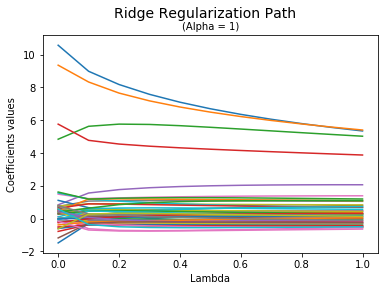

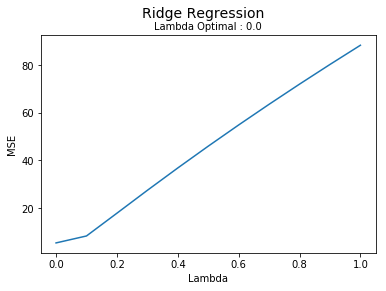

In [35]:
print_regularization_path(X_train,Y_train,isLasso=False)
lambda_opt_ridge, _, all_quad_risk = optimise_params(X_train, Y_train, X_test, Y_test, model_num=2)
print_plot("Ridge Regression","Lambda Optimal : " + str(lambda_opt_ridge),"Lambda","MSE")
plt.plot(all_quad_risk.columns,
         all_quad_risk.values.reshape(11, 1))

 * Elastic Net

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


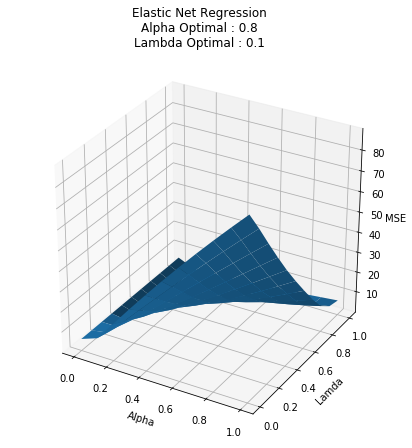

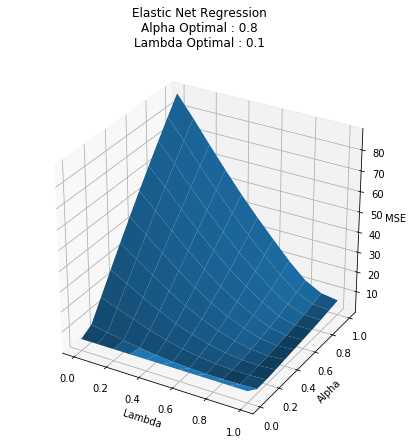

In [36]:
lambda_opt_elastic_net, alpha_opt_elastic_net, all_quad_risk = optimise_params(X_train, Y_train, X_test, Y_test, model_num=3)

print_plot3D("Elastic Net Regression\nAlpha Optimal : " + str(alpha_opt_elastic_net) +
          "\nLambda Optimal : " + str(lambda_opt_elastic_net),"", "Alpha", "Lamda", "MSE",
             np.linspace(0, 1, 11), np.linspace(0, 1, 11), all_quad_risk,0)

print_plot3D("Elastic Net Regression\nAlpha Optimal : " + str(alpha_opt_elastic_net) +
          "\nLambda Optimal : " + str(lambda_opt_elastic_net),"", "Lambda", "Alpha", "MSE",
             np.linspace(0, 1, 11), np.linspace(0, 1, 11), all_quad_risk,1)

opt_elastic_net=[]
opt_elastic_net.append(alpha_opt_elastic_net)
opt_elastic_net.append(lambda_opt_elastic_net)

 * Score

In [37]:
print_score(X_train,Y_train,lambda_opt_lasso,lambda_opt_ridge,opt_elastic_net)

              Score (R2)          MSE
Lasso           0.997821      1.68367
Ridge           0.993142      5.30039
Elastic Net     0.998388      1.24564
BEST MODEL   Elastic Net  Elastic Net


/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


# Exercice 2

Pour l'application à des données réelles, on choisi de partir d'un dataset sur le Bitcoin d'une quizaine de features, puis de faire du feature engineering sur ces features afin d'avoir une matrice de features de taille très importante (comme pour l'exercice 1).

On décide également d'introduire des features qui,vraisemblablement, n'auront pas d'effet sur la target : leurs coefficients de régression seront à priori nuls ! (et c'est ce qu'on souhaite).

On se retrouve finalement avec une matrice de (1337 * 127), qui parait être un bon candidat pour une régression pénalisée.

## Initialisation

 * Import des données

In [123]:
import datetime

df = pd.read_csv("bitcoin_dataset.csv")
df_2 = pd.read_csv("bitcoin_price.csv")
df_3 = pd.read_csv("litecoin_price.csv")
df_4 = pd.read_csv("monero_price.csv")

df_2 = df_2[::-1]
df_2 = df_2.reset_index(drop=True)

df_3 = df_3[::-1]
df_3 = df_3.reset_index(drop=True)

df_4 = df_4[::-1]
df_4 = df_4.reset_index(drop=True)

df["Date"] = df["Date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%S:%M"))
df_2["Date"] = df_2["Date"].apply(lambda x: datetime.datetime.strptime(x, "%b %d, %Y"))
df_3["Date"] = df_3["Date"].apply(lambda x: datetime.datetime.strptime(x, "%b %d, %Y"))
df_4["Date"] = df_4["Date"].apply(lambda x: datetime.datetime.strptime(x, "%b %d, %Y"))

df_3.columns = ["Date", "Open_Litecoin", "High_Litecoin", "Low_Litecoin",
                "Close_Litecoin", "Volume_Litecoin", "Market Cap_Litecoin"]

df_4.columns = ["Date", "Open_Monero", "High_Monero", "Low_Monero",
                "Close_Monero", "Volume_Monero", "Market Cap_Monero"]

df = df.merge(df_2)
df = df.merge(df_3)
df = df.merge(df_4)
df.head(5)

,Date,btc_market_price,btc_total_bitcoins,btc_market_cap,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,btc_median_confirmation_time,...,Low_Litecoin,Close_Litecoin,Volume_Litecoin,Market Cap_Litecoin,Open_Monero,High_Monero,Low_Monero,Close_Monero,Volume_Monero,Market Cap_Monero
0,2014-05-21,494.87,12798675.0,6.333680e+09,1.185312e+07,18419.0,0.250119,0.0,389.0,6.533333,...,10.53,10.59,"2,653,860","302,609,000",2.47,2.65,1.23,1.60,"246,540","2,079,640"
1,2014-05-22,523.84,12802850.0,6.706645e+09,2.358140e+07,18459.0,0.241909,2.0,519.0,7.450000,...,10.48,10.67,"5,186,880","302,201,000",1.59,2.19,1.36,2.10,"132,918","1,371,470"
2,2014-05-23,527.47,12806800.0,6.755203e+09,2.826269e+07,18501.0,0.271977,0.0,408.0,6.933333,...,10.65,11.23,"9,134,640","304,423,000",2.05,3.43,2.05,2.96,"266,852","1,816,200"
3,2014-05-24,521.52,12811000.0,6.681193e+09,9.312733e+06,18533.0,0.195074,0.0,503.0,7.350000,...,10.99,11.10,"2,574,380","320,801,000",2.92,4.01,2.62,3.70,"248,028","2,653,720"
4,2014-05-25,575.00,12814775.0,7.368496e+09,3.730564e+07,18566.0,0.219971,1.0,410.0,8.466667,...,11.12,11.53,"9,072,890","318,703,000",4.04,4.04,2.80,3.14,"283,545","3,774,890"


 * Feature Engineering

In [124]:
df["Open_Return"] = df["Open"].pct_change()
df["High_Return"] = df["High"].pct_change()
df["Low_Return"] = df["Low"].pct_change()
df["Close_Return"] = df["Close"].pct_change()

df["Open_Return_Litecoin"] = df["Open_Litecoin"].pct_change()
df["High_Return_Litecoin"] = df["High_Litecoin"].pct_change()
df["Low_Return_Litecoin"] = df["Low_Litecoin"].pct_change()
df["Close_Return_Litecoin"] = df["Close_Litecoin"].pct_change()

df["Open_Return_Monero"] = df["Open_Monero"].pct_change()
df["High_Return_Monero"] = df["High_Monero"].pct_change()
df["Low_Return_Monero"] = df["Low_Monero"].pct_change()
df["Close_Return_Monero"] = df["Close_Monero"].pct_change()

df["Volume"] = df["Volume"].apply(lambda x: float(x.replace(",", "")) if x != "-" else 0)
df["Market Cap"] = df["Market Cap"].apply(lambda x: float(x.replace(",", "")) if x != "-" else 0)

df["Volume_Litecoin"] = df["Volume_Litecoin"].apply(lambda x: float(x.replace(",", "")) if x != "-" else 0)
df["Market Cap_Litecoin"] = df["Market Cap_Litecoin"].apply(lambda x: float(x.replace(",", "")) if x != "-" else 0)

df["Volume_Monero"] = df["Volume_Monero"].apply(lambda x: float(x.replace(",", "")) if x != "-" else 0)
df["Market Cap_Monero"] = df["Market Cap_Monero"].apply(lambda x: float(x.replace(",", "")) if x != "-" else 0)

# Moyenne Mobile
for i_lag in [3, 6, 9]:
    df["Open_Return_MA" + str(i_lag) + "D"] = df["Open_Return"].rolling(i_lag).mean()
    df["High_Return_MA" + str(i_lag) + "D"] = df["High_Return"].rolling(i_lag).mean()
    df["Low_Return_MA" + str(i_lag) + "D"] = df["Low_Return"].rolling(i_lag).mean()
    df["Close_Return_MA" + str(i_lag) + "D"] = df["Close_Return"].rolling(i_lag).mean()

    df["Open_Return_Litecoin_MA" + str(i_lag) + "D"] = df["Open_Return_Litecoin"].rolling(i_lag).mean()
    df["High_Return_Litecoin_MA" + str(i_lag) + "D"] = df["High_Return_Litecoin"].rolling(i_lag).mean()
    df["Low_Return_Litecoin_MA" + str(i_lag) + "D"] = df["Low_Return_Litecoin"].rolling(i_lag).mean()
    df["Close_Return_Litecoin_MA" + str(i_lag) + "D"] = df["Close_Return_Litecoin"].rolling(i_lag).mean()

    df["Open_Return_Monero_MA" + str(i_lag) + "D"] = df["Open_Return_Monero"].rolling(i_lag).mean()
    df["High_Return_Monero_MA" + str(i_lag) + "D"] = df["High_Return_Monero"].rolling(i_lag).mean()
    df["Low_Return_Monero_MA" + str(i_lag) + "D"] = df["Low_Return_Monero"].rolling(i_lag).mean()
    df["Close_Return_Monero_MA" + str(i_lag) + "D"] = df["Close_Return_Monero"].rolling(i_lag).mean()

# Ecart Type Mobile
for i_lag in [3, 6, 9]:
    df["Open_Return_MA" + str(i_lag) + "D"] = df["Open_Return"].rolling(i_lag).std()
    df["High_Return_MA" + str(i_lag) + "D"] = df["High_Return"].rolling(i_lag).std()
    df["Low_Return_MA" + str(i_lag) + "D"] = df["Low_Return"].rolling(i_lag).std()
    df["Close_Return_MA" + str(i_lag) + "D"] = df["Close_Return"].rolling(i_lag).std()

    df["Open_Return_Litecoin_MA" + str(i_lag) + "D"] = df["Open_Return_Litecoin"].rolling(i_lag).std()
    df["High_Return_Litecoin_MA" + str(i_lag) + "D"] = df["High_Return_Litecoin"].rolling(i_lag).std()
    df["Low_Return_Litecoin_MA" + str(i_lag) + "D"] = df["Low_Return_Litecoin"].rolling(i_lag).std()
    df["Close_Return_Litecoin_MA" + str(i_lag) + "D"] = df["Close_Return_Litecoin"].rolling(i_lag).std()

    df["Open_Return_Monero_MA" + str(i_lag) + "D"] = df["Open_Return_Monero"].rolling(i_lag).std()
    df["High_Return_Monero_MA" + str(i_lag) + "D"] = df["High_Return_Monero"].rolling(i_lag).std()
    df["Low_Return_Monero_MA" + str(i_lag) + "D"] = df["Low_Return_Monero"].rolling(i_lag).std()
    df["Close_Return_Monero_MA" + str(i_lag) + "D"] = df["Close_Return_Monero"].rolling(i_lag).std()

# Skew Mobile
for i_lag in [3, 6, 9]:
    df["Open_Return_MA" + str(i_lag) + "D"] = df["Open_Return"].rolling(i_lag).skew()
    df["High_Return_MA" + str(i_lag) + "D"] = df["High_Return"].rolling(i_lag).skew()
    df["Low_Return_MA" + str(i_lag) + "D"] = df["Low_Return"].rolling(i_lag).skew()
    df["Close_Return_MA" + str(i_lag) + "D"] = df["Close_Return"].rolling(i_lag).skew()
    
    df["Open_Return_Litecoin_MA" + str(i_lag) + "D"] = df["Open_Return_Litecoin"].rolling(i_lag).skew()
    df["High_Return_Litecoin_MA" + str(i_lag) + "D"] = df["High_Return_Litecoin"].rolling(i_lag).skew()
    df["Low_Return_Litecoin_MA" + str(i_lag) + "D"] = df["Low_Return_Litecoin"].rolling(i_lag).skew()
    df["Close_Return_Litecoin_MA" + str(i_lag) + "D"] = df["Close_Return_Litecoin"].rolling(i_lag).skew()

    df["Open_Return_Monero_MA" + str(i_lag) + "D"] = df["Open_Return_Monero"].rolling(i_lag).skew()
    df["High_Return_Monero_MA" + str(i_lag) + "D"] = df["High_Return_Monero"].rolling(i_lag).skew()
    df["Low_Return_Monero_MA" + str(i_lag) + "D"] = df["Low_Return_Monero"].rolling(i_lag).skew()
    df["Close_Return_Monero_MA" + str(i_lag) + "D"] = df["Close_Return_Monero"].rolling(i_lag).skew()

# Cosinus sur Moyenne Mobile
for i_lag in [3, 6, 9]:
    df["Open_Return_Cosinus_MA_" + str(i_lag) + "D"] = \
        df["Open_Return_MA" + str(i_lag) + "D"].apply(lambda x: np.cos(x))
    df["High_Return_Cosinus_MA_" + str(i_lag) + "D"] = \
        df["High_Return_MA" + str(i_lag) + "D"].apply(lambda x: np.cos(x))
    df["Low_Return_Cosinus_MA_" + str(i_lag) + "D"] = \
        df["Low_Return_MA" + str(i_lag) + "D"].apply(lambda x: np.cos(x))
    df["Close_Return_Cosinus_MA_" + str(i_lag) + "D"] = \
        df["Close_Return_MA" + str(i_lag) + "D"].apply(lambda x: np.cos(x))

# Sinus sur Moyenne Mobile
for i_lag in [3, 6, 9]:
    df["Open_Return_Sinus_MA_" + str(i_lag) + "D"] = \
        df["Open_Return_MA" + str(i_lag) + "D"].apply(lambda x: np.sin(x))
    df["High_Return_Sinus_MA_" + str(i_lag) + "D"] = \
        df["High_Return_MA" + str(i_lag) + "D"].apply(lambda x: np.sin(x))
    df["Low_Return_Sinus_MA_" + str(i_lag) + "D"] = \
        df["Low_Return_MA" + str(i_lag) + "D"].apply(lambda x: np.sin(x))
    df["Close_Return_Sinus_MA_" + str(i_lag) + "D"] = \
        df["Close_Return_MA" + str(i_lag) + "D"].apply(lambda x: np.sin(x))

# Exp sur Moyenne Mobile
for i_lag in [3, 6, 9]:
    df["Open_Return_Exp_MA_" + str(i_lag) + "D"] = \
        df["Open_Return_MA" + str(i_lag) + "D"].apply(lambda x: np.exp(x))
    df["High_Return_Exp_MA_" + str(i_lag) + "D"] = \
        df["High_Return_MA" + str(i_lag) + "D"].apply(lambda x: np.exp(x))
    df["Low_Return_Exp_MA_" + str(i_lag) + "D"] = \
        df["Low_Return_MA" + str(i_lag) + "D"].apply(lambda x: np.exp(x))
    df["Close_Return_Exp_MA_" + str(i_lag) + "D"] = \
        df["Close_Return_MA" + str(i_lag) + "D"].apply(lambda x: np.exp(x))

# Classification
# Création de la Target : signal d'achat ou de vente
#dataset["target"] = \
#    [1 if dataset.loc[row + 1, "btc_return"] > 0 else 0
#     for row in range(0, len(dataset.loc[:, "btc_return"]))]

# Regression
# Création de la target : rentabilité du jour d'après
df["Target"] = df["Close_Return"].shift(-1)

df = df.reindex(
    np.concatenate((["Date", "Target"], df.columns[1:-1].tolist())),
    axis=1)

df = df.dropna().reset_index(drop=True)
df.head(5)

,Date,Target,btc_market_price,btc_total_bitcoins,btc_market_cap,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,...,Low_Return_Exp_MA_3D,Close_Return_Exp_MA_3D,Open_Return_Exp_MA_6D,High_Return_Exp_MA_6D,Low_Return_Exp_MA_6D,Close_Return_Exp_MA_6D,Open_Return_Exp_MA_9D,High_Return_Exp_MA_9D,Low_Return_Exp_MA_9D,Close_Return_Exp_MA_9D
0,2014-05-30,0.013570,609.03,12834000.0,7.816291e+09,2.175838e+07,18761.0,0.234589,1.0,363.0,...,0.288141,3.510433,5.463303,2.221119,3.947754,1.714983,3.271087,1.476899,2.654409,1.773699
1,2014-05-31,0.010502,620.45,12837800.0,7.965213e+09,1.080980e+07,18793.0,0.211037,0.0,459.0,...,3.837640,3.049477,1.842962,4.549867,1.681664,3.991242,1.869539,2.403294,1.579691,3.007898
2,2014-06-01,0.048220,674.98,12842275.0,8.668279e+09,3.394311e+07,18827.0,0.192052,1.0,438.0,...,3.437376,5.590915,4.711021,2.076485,2.190026,4.937080,3.260566,1.719723,2.268653,2.886790
3,2014-06-04,0.018843,644.66,12856025.0,8.287765e+09,2.831485e+07,18943.0,0.207971,0.0,411.0,...,1.586938,0.667321,2.717718,2.081822,0.627698,1.169969,3.384024,3.633603,1.148574,2.199385
4,2014-06-06,0.001943,655.75,12863350.0,8.435142e+09,1.286732e+07,19021.0,0.264822,2.0,421.0,...,0.182540,0.202531,2.955675,6.960447,0.379141,0.408644,3.902769,3.674279,0.667117,1.764899


 * Normalisation des données

In [125]:
dataset = df
# Min-Max Scalings
dataset.iloc[:, 1:] = dataset.iloc[:, 1:].apply(lambda x: (x - np.min(x))/(np.max(x) - np.min(x)))

dataset.head(10)

,Date,Target,btc_market_price,btc_total_bitcoins,btc_market_cap,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,...,Low_Return_Exp_MA_3D,Close_Return_Exp_MA_3D,Open_Return_Exp_MA_6D,High_Return_Exp_MA_6D,Low_Return_Exp_MA_6D,Close_Return_Exp_MA_6D,Open_Return_Exp_MA_9D,High_Return_Exp_MA_9D,Low_Return_Exp_MA_9D,Close_Return_Exp_MA_9D
0,2014-05-30,0.485048,0.022385,0.000000,0.016643,0.003575,0.000000,0.073250,0.142857,0.041436,...,0.020313,0.608826,0.500525,0.191485,0.368380,0.152270,0.219382,0.088035,0.164014,0.118860
1,2014-05-31,0.478435,0.022976,0.000940,0.017103,0.001528,0.000231,0.048326,0.000000,0.080435,...,0.668587,0.524638,0.162842,0.400767,0.151991,0.365816,0.123296,0.145602,0.096204,0.204594
2,2014-06-01,0.559737,0.025798,0.002048,0.019272,0.005853,0.000476,0.028235,0.142857,0.071904,...,0.595484,0.988801,0.430357,0.178487,0.200535,0.454549,0.218661,0.103124,0.139674,0.196181
3,2014-06-04,0.496414,0.024229,0.005450,0.018098,0.004801,0.001312,0.045082,0.000000,0.060935,...,0.257523,0.089566,0.244434,0.178967,0.051348,0.101140,0.227125,0.222055,0.069002,0.148430
4,2014-06-06,0.459986,0.024803,0.007263,0.018552,0.001913,0.001874,0.105245,0.285714,0.064998,...,0.001026,0.004677,0.266629,0.617403,0.027614,0.029717,0.262688,0.224583,0.038625,0.118249
5,2014-06-07,0.459648,0.024728,0.008209,0.018503,0.001767,0.002090,0.037778,0.285714,0.055248,...,0.408491,0.027083,0.318354,0.741408,0.060061,0.043875,0.297693,0.244211,0.053619,0.128334
6,2014-06-08,0.432868,0.024609,0.009137,0.018419,0.000632,0.002299,0.034673,0.285714,0.051186,...,0.236051,0.999488,0.445188,0.339706,0.077338,0.057650,0.308350,0.239730,0.043217,0.124655
7,2014-06-09,0.469047,0.024554,0.009979,0.018383,0.002094,0.002544,0.094944,0.142857,0.030061,...,0.942956,0.000030,0.568597,0.247656,0.095129,0.017751,0.346795,0.722995,0.055810,0.049512
8,2014-06-10,0.389366,0.024500,0.011074,0.018351,0.001982,0.002832,0.066179,0.285714,0.011375,...,0.051654,0.019669,0.141806,0.091603,0.130587,0.017846,0.389390,0.809245,0.062254,0.056779
9,2014-06-11,0.298925,0.023987,0.011977,0.017965,0.002705,0.003092,0.091972,0.142857,0.024374,...,0.486011,0.106510,0.089555,0.059537,0.306438,0.030135,0.494066,0.167831,0.104012,0.077423


## Estimation du modèle

 * Séparation du dataset en train / test set

In [126]:
# Splitting X in training and testing set
train_set, test_set = skl_mdl_selection.train_test_split(dataset,
                                                        train_size=0.66,
                                                        test_size=0.34)

X_train = train_set.iloc[:, 2:]
Y_train = train_set.iloc[:, 1]
X_test = test_set.iloc[:, 2:]
Y_test = test_set.iloc[:, 1]

X_train.head(5)

,btc_market_price,btc_total_bitcoins,btc_market_cap,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,btc_median_confirmation_time,btc_hash_rate,...,Low_Return_Exp_MA_3D,Close_Return_Exp_MA_3D,Open_Return_Exp_MA_6D,High_Return_Exp_MA_6D,Low_Return_Exp_MA_6D,Close_Return_Exp_MA_6D,Open_Return_Exp_MA_9D,High_Return_Exp_MA_9D,Low_Return_Exp_MA_9D,Close_Return_Exp_MA_9D
417,0.004602,0.406774,0.004383,0.002842,0.164505,0.218889,0.428571,0.220992,0.105634,0.010771,...,0.002852,0.004956,0.005697,0.002987,0.002543,0.009349,0.004433,0.005271,0.003627,0.005421
625,0.011619,0.605905,0.011435,0.009023,0.302944,0.643204,0.000000,0.379830,0.116197,0.047577,...,0.031828,0.999579,0.062438,0.065590,0.104093,0.167555,0.043817,0.020711,0.041174,0.061209
31,0.024197,0.035176,0.018312,0.001447,0.008806,0.124665,0.142857,0.069466,0.109155,0.001262,...,0.928016,0.255520,0.335948,0.564966,0.527932,0.576896,0.118522,0.231817,0.159569,0.118191
949,0.037084,0.814424,0.036931,0.005050,0.582884,0.870451,0.142857,0.722588,0.295070,0.111808,...,0.110487,0.042182,0.146475,0.208309,0.025065,0.068369,0.417839,0.433807,0.029055,0.334613
595,0.010794,0.577429,0.010546,0.007294,0.278031,0.494704,0.000000,0.448484,0.054930,0.040191,...,0.031696,0.653416,0.036335,0.937034,0.104486,0.324257,0.015288,0.372724,0.062221,0.161905


 #### A) On estime la Régression Elastic Net pour alpha variant de 0 à 1

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0.5,0,'Alpha')

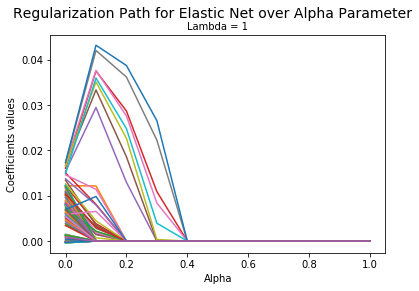

In [127]:
# ATTENTION : dans la fonction ElasticNet de sklearn, le paramètre
# l1_ratio correspond au alpha de la formule du projet, 
# tandis que le paramètre alpha correspond au lambda de la formule du projet ...

all_beta_chap = dict()
#models = list()
alpha_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for i_alpha in alpha_range:
    en = skl_linear_mdl.ElasticNet(l1_ratio=i_alpha, fit_intercept=False, max_iter = 10000)
    en.fit(X_train, Y_train)
    beta_chap = en.coef_
    all_beta_chap.update({i_alpha: beta_chap})
    #models.append(en)

beta_vs_alpha = pd.DataFrame(all_beta_chap)

plt.figure()
plt.suptitle("Regularization Path for Elastic Net over Alpha Parameter",
            fontsize=14)
plt.title("Lambda = 1", fontsize=10)
for row in beta_vs_alpha.iterrows():
    row = row[1]
    plt.plot(alpha_range, row)
plt.ylabel("Coefficients values")
plt.xlabel("Alpha") 

 #### B) Lasso Regularization Path

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


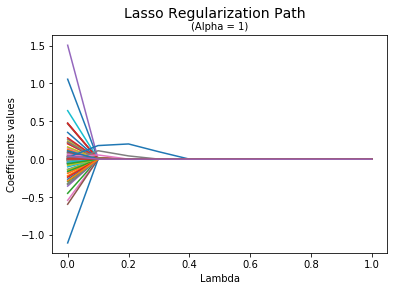

In [142]:
print_regularization_path(X_train,Y_train,isLasso=True)

Text(0.5,0,'Lambda')

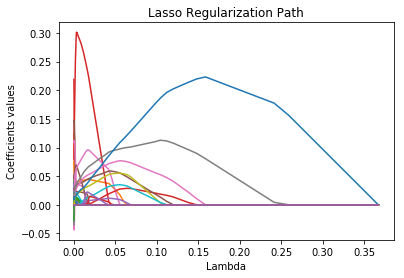

In [143]:
lasso = skl_linear_mdl.ElasticNet(l1_ratio=1, fit_intercept= False, max_iter = 10000)
lasso_path = lasso.path(X_train, Y_train, l1_ratio=1)
lasso_path_result = lasso_path[1]
plt.figure()
plt.title("Lasso Regularization Path")
for i in range(0, len(lasso_path_result)):
    plt.plot(lasso_path[0], lasso_path_result[i])
plt.ylabel("Coefficients values")
plt.xlabel("Lambda")

#### B.1) Ridge Regularization Path

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


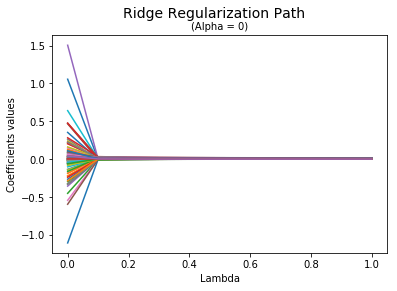

In [144]:
print_regularization_path(X_train,Y_train,isLasso=False)

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0.5,0,'Lambda')

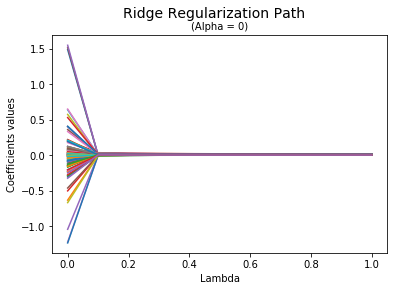

In [145]:
# Méthode 1.1) Avec une boucle
all_beta_chap = dict()
lambda_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for i_lambda in lambda_range:
    ridge = skl_linear_mdl.ElasticNet(alpha=i_lambda, l1_ratio=0, fit_intercept=False, max_iter = 10000)
    ridge.fit(X_train, Y_train)
    beta_chap = ridge.coef_
    all_beta_chap.update({i_lambda: beta_chap})

beta_vs_lambda = pd.DataFrame(all_beta_chap)

# Méthode 1.2) Avec la méthode Path
ridge = skl_linear_mdl.ElasticNet(l1_ratio=1, fit_intercept=False, max_iter = 10000)
lasso_path = ridge.path(X_train, Y_train, l1_ratio=1)

plt.figure()
plt.suptitle("Ridge Regularization Path", fontsize=14)
plt.title("(Alpha = 0)", fontsize=10)
for row in beta_vs_lambda.iterrows():
    row = row[1]
    plt.plot(lambda_range, row)
plt.ylabel("Coefficients values")
plt.xlabel("Lambda")  

 ### Optimisation du / des paramètres de régularisation (lambda et alpha)

 * Lasso

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


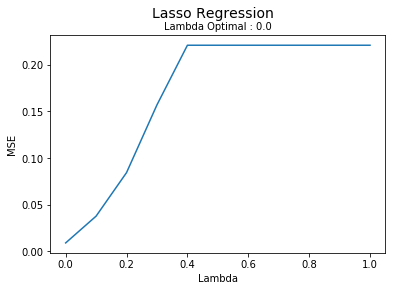

In [159]:
lambda_opt_lasso, _, all_quad_risk = optimise_params(X_train, Y_train, X_test, Y_test, model_num=1)
print_plot("Lasso Regression","Lambda Optimal : " + str(lambda_opt_lasso),"Lambda","MSE")
plt.plot(all_quad_risk.columns,
         all_quad_risk.values.reshape(11, 1))

 * Ridge

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


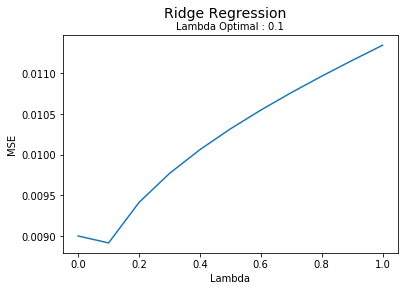

In [160]:
lambda_opt_ridge, _, all_quad_risk = optimise_params(X_train, Y_train, X_test, Y_test, model_num=2)
print_plot("Ridge Regression","Lambda Optimal : " + str(lambda_opt_ridge),"Lambda","MSE")
plt.plot(all_quad_risk.columns,
         all_quad_risk.values.reshape(11, 1))

 * Elastic Net

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


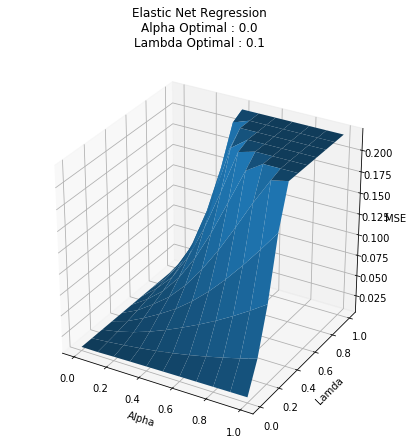

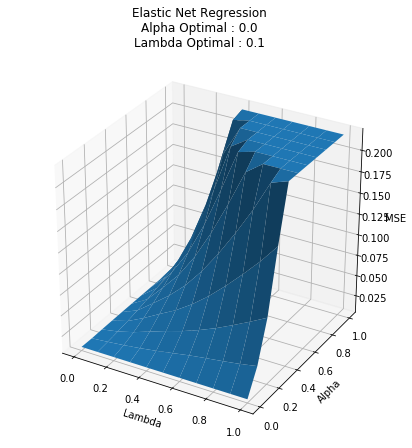

In [161]:
lambda_opt_elastic_net, alpha_opt_elastic_net, all_quad_risk = optimise_params(X_train, Y_train, X_test, Y_test, model_num=3)

print_plot3D("Elastic Net Regression\nAlpha Optimal : " + str(alpha_opt_elastic_net) +
          "\nLambda Optimal : " + str(lambda_opt_elastic_net),"", "Alpha", "Lamda", "MSE",
             np.linspace(0, 1, 11), np.linspace(0, 1, 11), all_quad_risk,0)

print_plot3D("Elastic Net Regression\nAlpha Optimal : " + str(alpha_opt_elastic_net) +
          "\nLambda Optimal : " + str(lambda_opt_elastic_net),"", "Lambda", "Alpha", "MSE",
             np.linspace(0, 1, 11), np.linspace(0, 1, 11), all_quad_risk,1)

opt_elastic_net=[]
opt_elastic_net.append(alpha_opt_elastic_net)
opt_elastic_net.append(lambda_opt_elastic_net)

 * Score des estimateurs

In [162]:
print_score(X_train,Y_train,lambda_opt_lasso,lambda_opt_ridge,opt_elastic_net)

/Users/virgileamato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/virgileamato/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


            Score (R2)         MSE
Lasso        -0.356518  0.00899991
Ridge        -0.343664  0.00891463
Elastic Net  -0.343664  0.00891463
BEST MODEL       Ridge       Ridge
